# PCA Analysis

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#import plotly.express as px
from classes_script import PcaAnalyzer, ClustererPcad
from sklearn.preprocessing import StandardScaler 


In [2]:
df = pd.read_csv('./data/marketing_data.csv')
print(df.shape)
#Preprocess Income
df['Income']=df[' Income ']
df['Income']=df.Income.str.replace('$','')
df['Income']=df.Income.str.replace(',','')#.astype("Int64")
df['Income']=df.Income.astype("float")
df['Income'].fillna((df['Income'].median()), inplace=True)
df = df.drop([' Income '], axis=1)
df.drop(df.index[[527,513,827,2233]],inplace=True) #drop income outlier 527 and age outliers
initial = df.shape[0]
df= df[df['Income']<120000]
post_drop =  df.shape[0]
print(f"{initial-post_drop} observations dropped from income over 120K")
df['LogIncome'] = np.log1p(df['Income'])


#Preprocess Education
df.loc[df['Education']=='2n Cycle','Education']='Master'
df.loc[df['Education']=='Graduation','Education']='Bachelor'

#Preprocess Children
df['NumChildren']  = df['Kidhome']+df['Teenhome']
df['HasChildren']=np.where(df.NumChildren> 0, 1, 0)

#Preprocess Marital Status
df['HasPartner']=np.where(((df.Marital_Status== 'Married')|(df.Marital_Status== 'Together')), 1, 0)

#Preprocess Date and Make Age
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
df['age'] = 2014 - df['Year_Birth']

#Make total spending, num promotions, and num orders accepted columns
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] +\
        +df['MntSweetProducts'] + df['MntGoldProds']
df['AcceptedCmpTot']=df['AcceptedCmp1']+ df['AcceptedCmp2']+ df['AcceptedCmp3']+ df['AcceptedCmp4']+\
       + df['AcceptedCmp5']
df['NumTotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases']+df['NumCatalogPurchases']+\
    df['NumStorePurchases']+df['NumWebVisitsMonth']

# Make a column for spending normalized by length customer -> Consider doing this for other amounts as well
latest_date=(df["Dt_Customer"] + pd.to_timedelta(df['Recency'],'d')).max()
df['Len_Customer']=latest_date - df["Dt_Customer"]
df['Len_Customer']=df['Len_Customer'] / pd.to_timedelta(1, unit='D') #Convert to float
df['MntSpentNorm']=df['MntTotal']/df['Len_Customer']

(2240, 28)
7 observations dropped from income over 120K


In [3]:
df.to_csv('data/marketing_data80.csv')

In [5]:
df.shape

(2229, 38)

In [6]:
cats = {'Education', 'Marital_Status', 
       'Kidhome', 'Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain','Country','HasChildren','HasPartner',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes


nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer','LogIncome','MntTotal', 'AcceptedCmpTot','NumTotalPurchases','Year_Birth'} #drop some highly correlated transformed vars

#X = df.drop(list(nums),axis=1) #Dropping Dt_Customer since this is causing problems in RF
X = df[list(nums)] #Dropping Dt_Customer since this is causing problems in RF

In [7]:
X.columns

Index(['MntWines', 'Len_Customer', 'NumWebPurchases', 'MntSweetProducts',
       'age', 'NumWebVisitsMonth', 'NumStorePurchases', 'NumCatalogPurchases',
       'NumChildren', 'Recency', 'MntFruits', 'MntSpentNorm',
       'MntFishProducts', 'Income', 'MntGoldProds', 'NumDealsPurchases',
       'MntMeatProducts'],
      dtype='object')

In [8]:
cats = {'Education', 'Marital_Status', 
       'Kidhome', 'Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain','Country','HasChildren','HasPartner',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes


nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer','LogIncome','MntTotal', 'AcceptedCmpTot','NumTotalPurchases','Year_Birth',
'MntSweetProducts','MntFruits'} #drop some highly correlated transformed vars

#X = df.drop(list(nums),axis=1) #Dropping Dt_Customer since this is causing problems in RF
X = df[list(nums)] #Dropping Dt_Customer since this is causing problems in RF

In [9]:
X.head()

,MntWines,Len_Customer,NumWebPurchases,age,NumWebVisitsMonth,NumStorePurchases,NumCatalogPurchases,NumChildren,Recency,MntSpentNorm,MntFishProducts,Income,MntGoldProds,NumDealsPurchases,MntMeatProducts
0,189,110.0,4,44,1,6,4,0,0,10.818182,111,84835.0,218,1,379
1,464,111.0,7,53,5,7,3,0,0,5.198198,7,57091.0,37,1,64
2,134,144.0,3,56,2,5,2,1,0,1.743056,15,67267.0,30,1,59
3,10,146.0,1,47,7,2,0,2,0,0.075342,0,32474.0,0,1,1
4,6,179.0,3,25,7,2,1,1,0,0.508380,11,21474.0,34,2,24


In [10]:
len(X.columns)

15

In [11]:
X.columns

Index(['MntWines', 'Len_Customer', 'NumWebPurchases', 'age',
       'NumWebVisitsMonth', 'NumStorePurchases', 'NumCatalogPurchases',
       'NumChildren', 'Recency', 'MntSpentNorm', 'MntFishProducts', 'Income',
       'MntGoldProds', 'NumDealsPurchases', 'MntMeatProducts'],
      dtype='object')

In [12]:
LOG_COLS = ['NumChildren', 'NumWebPurchases',  #most columns have long right tails, so log them; income outliers already dropped
        'NumWebVisitsMonth', 'MntWines', 'MntSpentNorm',
        'MntFishProducts', 'MntMeatProducts',
       'NumDealsPurchases', 'NumCatalogPurchases', 
       'MntGoldProds']
SUBSET=[] # just use all cols
PCA_PCT = .8

In [13]:
# fig,ax = plt.subplots()
# ax.boxplot(X['Income'])

## PCA Analysis

In [15]:
pca80 = PcaAnalyzer(data=X,subset=SUBSET,log_cols=LOG_COLS,Scaler=StandardScaler,pca_pct=0.8)


There are 5 components numbered 1 through 5


Proportion of variance explained by the 5 PCA components (largest to smallest)
[0.46417249 0.13824362 0.08257871 0.06703257 0.05772198]
Cumulative variance explained by the 5 PCA components (largest to smallest)
[0.46417249 0.60241611 0.68499482 0.75202739 0.80974937]
PCA Loadings
                          PC1       PC2       PC3       PC4       PC5
variable                                                             
MntWines            -0.335063  0.176271  0.145340  0.011499 -0.009263
Len_Customer        -0.028366  0.374877 -0.547009 -0.074003  0.508194
NumWebPurchases     -0.269054  0.332588  0.027010  0.056780 -0.126463
age                 -0.070938  0.111167  0.569468 -0.123764  0.738304
NumWebVisitsMonth    0.238137  0.402128 -0.127204  0.044656 -0.020991
NumStorePurchases   -0.300304  0.094883  0.048486  0.034294 -0.055826
NumCatalogPurchases -0.343491  0.032606 -0.011466 -0.022659  0.031841
NumChildren          0.207491  0.368149  0.355791 -0.002789 -0.207686
Recency           

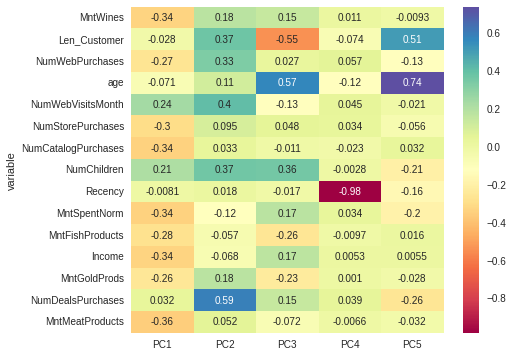

Scree plot


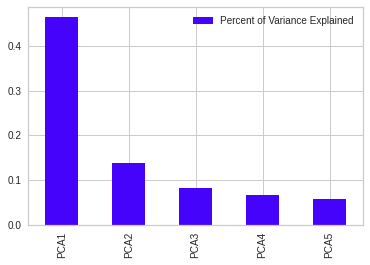

In [16]:
pca80.pca_explainer()

Proportion of variance explained by the 5 PCA components (largest to smallest)
[0.46417249 0.13824362 0.08257871 0.06703257 0.05772198]
Cumulative variance explained by the 5 PCA components (largest to smallest)
[0.46417249 0.60241611 0.68499482 0.75202739 0.80974937]
PCA Loadings
                          PC1       PC2       PC3       PC4       PC5
variable                                                             
Income              -0.335532 -0.068311  0.170062  0.005302  0.005518
age                 -0.070938  0.111167  0.569468 -0.123764  0.738304
MntGoldProds        -0.257300  0.175198 -0.232913  0.001050 -0.028172
NumDealsPurchases    0.032160  0.585117  0.145352  0.038936 -0.260027
MntMeatProducts     -0.355315  0.052079 -0.071786 -0.006604 -0.032169
NumWebPurchases     -0.269054  0.332588  0.027010  0.056780 -0.126463
MntFishProducts     -0.281127 -0.057403 -0.263493 -0.009663  0.015619
MntSpentNorm        -0.341188 -0.118596  0.173871  0.033937 -0.195082
NumStorePurchases 

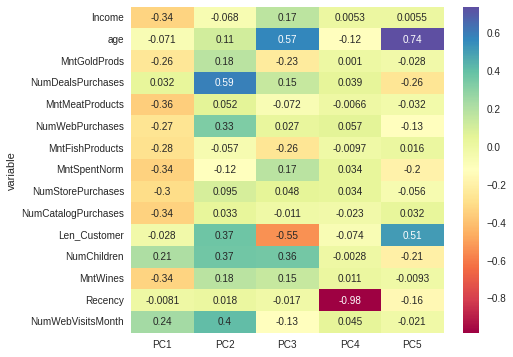

Scree plot


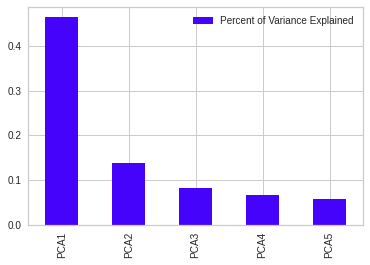

In [15]:
pca80.pca_explainer()

In [17]:
pcas=pca80.get_select_components_df(pca_indices=[1,2,3,4,5])

- Choose 5 components to explain 80% of the variancem

In [20]:
print(pcas.shape)
assert df.shape[0]==pcas.shape[0]

(2229, 5)


In [19]:
pcas.to_csv('data/pcas80.csv')

#### Explore the full PCA matrix to look for additional patterns

In [23]:
pca999 = PcaAnalyzer(data=X,subset=SUBSET,log_cols=LOG_COLS,Scaler=StandardScaler,pca_pct=.999)


There are 15 components numbered 1 through 15


Proportion of variance explained by the 15 PCA components (largest to smallest)
[0.46417249 0.13824362 0.08257871 0.06703257 0.05772198 0.03903882
 0.03423499 0.02832792 0.02364815 0.02200966 0.01424152 0.01025792
 0.00728316 0.0059279  0.0052806 ]
Cumulative variance explained by the 15 PCA components (largest to smallest)
[0.46417249 0.60241611 0.68499482 0.75202739 0.80974937 0.84878819
 0.88302317 0.91135109 0.93499924 0.9570089  0.97125042 0.98150834
 0.9887915  0.9947194  1.        ]
PCA Loadings
                          PC1       PC2       PC3       PC4       PC5  \
variable                                                                
MntWines            -0.335063  0.176271  0.145340  0.011499 -0.009263   
Len_Customer        -0.028366  0.374877 -0.547009 -0.074003  0.508194   
NumWebPurchases     -0.269054  0.332588  0.027010  0.056780 -0.126463   
age                 -0.070938  0.111167  0.569468 -0.123764  0.738304   
NumWebVisitsMonth    0.238137  0.402128 -0.127204  0.0

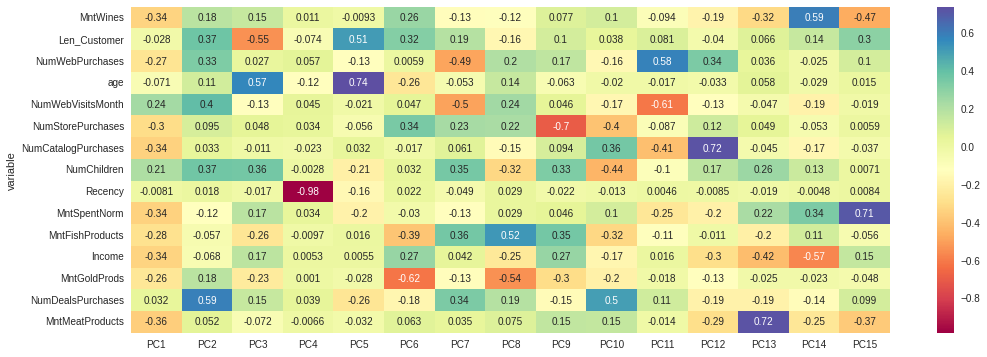

Scree plot


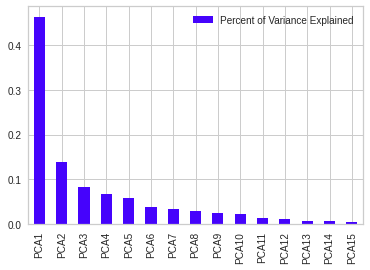

In [24]:
pca999.pca_explainer()

- The principal components past 5 account for less an less of the variance (PC6 accounts for less than 5% already)